In [14]:
# !pip install pyLDAvis
# !pip install mallet
# !pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 139.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 45.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvic

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import mallet
import os
import re
import nltk

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint

In [ ]:
df = pd.read_csv("tweets_v172_final.csv")

In [ ]:
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_row', 100)

## Preprocessing

In [ ]:
df.shape

In [20]:
df.rename(columns = {'text':'Tweet'}, inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
#Remove URL from tweet text
df['Text'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+', '',x))
#Remove mention (@user)
df['Text'] = df['Text'].apply(lambda x: re.sub(r'@\S+', '',x))
#All lowercases
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
#Remove Punctuation
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
df.Text[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'read aigenerated academic science writing can be identified with over 99 accuracy for more get the app from llm gpt ai ml dl chatgpt research genai'

In [26]:
df.Tweet[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Read "AI-generated academic science writing can be identified with over 99% accuracy" https://t.co/qZcnOWEEqj\n\nFor more, get the app from\nhttps://t.co/0ic5ya66on\n\n#LLM #GPT #AI #ML #DL #ChatGPT #research #GenAI https://t.co/aYrXTQFq6P'

In [27]:
#Replace 'chat gpt' with 'chatgpt'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'chat gpt', 'chatgpt', x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
nltk.download('all')

#remove stopwords, short tokens, and accents
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
#simple_preprocess: Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
df['Token'] = df['Text'].apply(lambda x: [word for word in simple_preprocess(x) if word not in stopwords])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:
#Build the bigram and trigrams
bigram = Phrases(df['Token'], min_count=100, threshold=100)
# #bigram[df['Token']] will apply the bigram object to each row of the df['Token'] column
df['Bigram'] = bigram[df['Token']]
bigram_mod = gensim.models.phrases.Phraser(bigram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
trigram = Phrases(df['Bigram'], min_count=100, threshold=100)
df['Trigram'] = trigram[df['Bigram']]
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
df[df['Trigram']!=df['Bigram']][0:50]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_name,Tweet,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,sentiment,Text,Token,Bigram,Trigram


In [34]:
# Get the bigram and trigram phrases
biphrase = bigram.export_phrases()
triphrase = trigram.export_phrases()
print(f'Bi:{len(biphrase)}, Tri:{len(triphrase)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Bi:2, Tri:2


In [35]:
biphrase, triphrase

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


({'artificial_intelligence': 261.5692800362898,
  'medical_licensing': 162.79594861660078},
 {'artificial_intelligence': 23660.215384615385,
  'medical_licensing': 9354.124454148472})

In [36]:
# Get the bigram and trigram vocabularies
bigram_vocab = bigram.vocab
trigram_vocab = trigram.vocab

# Sort the bigram and trigram vocabularies by frequency in descending order
sorted_bigram_vocab = sorted(biphrase.items(), key=lambda x: x[1], reverse=True)
sorted_trigram_vocab = sorted(triphrase.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most common bigrams and trigrams
print("Top 20 most common bigrams:")
for phrase, freq in sorted_bigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

print("\nTop 20 most common trigrams:")
for phrase, freq in sorted_trigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

Top 20 most common bigrams:
artificial_intelligence: 261.5692800362898
medical_licensing: 162.79594861660078

Top 20 most common trigrams:
artificial_intelligence: 23660.215384615385
medical_licensing: 9354.124454148472


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
import time

# bi-gram and tri-gram implementation
start_time = time.time()
df['Token'] = df['Token'].apply(lambda x:bigram_mod[x])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken1: {total_time:.2f} seconds")

start_time = time.time()
df['Token']= df['Token'].apply(lambda x:trigram_mod[bigram_mod[x]])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken2: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken1: 0.23 seconds
Total time taken2: 0.44 seconds


In [42]:
#Lemmatization
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#define a function to map POS tags from treebank tag into wordnet tags
wnl = WordNetLemmatizer()
def get_wordnet(pos):
    if pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN     #default to noun if no match


# Define a function to tag and lemmatize a text string
def lemmatizer(text):
    pos_tags = pos_tag(text)
    text = [wnl.lemmatize(word, pos = get_wordnet(pos)) for word, pos in pos_tags]
    return text

start_time = time.time()

df['Lemmatized'] = df['Token'].apply(lambda x: lemmatizer(x))

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken: 18.05 seconds


In [43]:
# remove stopwords and short tokens again after lemmatization
df['Text_new'] = df['Lemmatized'].apply(lambda x: ' '.join(x))
df['Tokens'] = df['Text_new'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True, min_len=3, max_len=50) if word not in stopwords])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#df = df.drop(columns =['Text', 'Token', 'Lemmatized', 'Text_new'])
df.to_csv('Twitter_english_clean.csv',index=False)

## Create the Dictionary and Corpus

In [47]:
df.Tokens.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count                                                 18755
unique                                                18182
top       [world, change, next, week, gpt, time, powerfu...
freq                                                     18
Name: Tokens, dtype: object

In [ ]:
df = pd.read_csv('../Data/Twitter_english_clean.csv')

In [49]:
import ast
# # convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
df['Tokens'] = df['Tokens'].apply(lambda x: ast.literal_eval(str(x)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
dictionary = Dictionary(df['Tokens'])
print(f'Total vocabulary size: {len(dictionary)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total vocabulary size: 23641


In [51]:
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
#create a dictionary to show the word and frequency in the corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# Top 10 high-frequency words
df_dict.sort_values('frequency', ascending = False).head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,frequency
chatgpt,24050
learn,6596
education,5697
use,4526
student,3486
write,2123
amp,2115
school,2032
teacher,1773
teach,1714


In [54]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5)  #words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 2961


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Recreate the corpus for LDA model
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
# Re-check the top words
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict_new = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])
df_dict_new.sort_values('frequency', ascending = False).head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,frequency
learn,6596
education,5697
use,4526
student,3486
write,2123
amp,2115
school,2032
teacher,1773
teach,1714
tool,1665


In [57]:
# Generate a test corpus
corpus_test = [dictionary.doc2bow(doc) for doc in df['Tokens'][0:1000]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
len(corpus),len(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(18755, 2961)

## LDA Model Implementation

In [59]:
import time
import logging
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
num_topics = 10
passes = 10
total_iteration = num_topics*passes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
start_time =time.time()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# train the LdaModel
lda_model = LdaModel(corpus=corpus_test, id2word=dictionary, num_topics=num_topics, passes=passes)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken: 3.75 seconds


In [62]:
# Display topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('learn', 0.02525173),
   ('use', 0.016703377),
   ('tool', 0.013417892),
   ('student', 0.0107619865),
   ('education', 0.010385795),
   ('course', 0.008865097),
   ('read', 0.0087687075),
   ('teach', 0.008488571),
   ('tech', 0.007582881),
   ('like', 0.0070023984)]),
 (1,
  [('use', 0.033125535),
   ('education', 0.024756258),
   ('student', 0.017305693),
   ('learn', 0.013024249),
   ('homework', 0.010710811),
   ('get', 0.010305825),
   ('see', 0.008076623),
   ('amp', 0.007629553),
   ('way', 0.007391504),
   ('work', 0.0071293116)]),
 (2,
  [('learn', 0.026642814),
   ('kid', 0.025371943),
   ('education', 0.023366967),
   ('teacher', 0.016728308),
   ('read', 0.01452578),
   ('health', 0.014214551),
   ('via', 0.013589073),
   ('use', 0.01096463),
   ('machine', 0.010739321),
   ('autism', 0.010434865)]),
 (3,
  [('education', 0.018980213),
   ('student', 0.017275754),
   ('use', 0.0150301065),
   ('university', 0.0132260965),
   ('tool', 0.010707533),
   ('exam', 0.00

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
#Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus = corpus, coherence='c_v', texts=df['Tokens'])
coherence = cm.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
print(f'Coherence score: {coherence}')

Coherence score: 0.2545301342213452


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
# To increase the speed, use a multicore Lda model
from gensim.models.ldamulticore import LdaMulticore
start_time =time.time()
#Train the LdaMulticore model
lda_model_m = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, workers=10)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken: 64.44 seconds


In [66]:
pprint(lda_model_m.show_topics(formatted=False))

[(0,
  [('learn', 0.02582323),
   ('education', 0.01292359),
   ('use', 0.012320459),
   ('machine', 0.011065097),
   ('data', 0.009934131),
   ('tool', 0.008992881),
   ('learning', 0.008969587),
   ('new', 0.008748732),
   ('say', 0.008434623),
   ('school', 0.007862168)]),
 (1,
  [('learn', 0.05766323),
   ('education', 0.022221748),
   ('machine', 0.015228434),
   ('technology', 0.012545743),
   ('learning', 0.008084865),
   ('openai', 0.00751255),
   ('machinelearning', 0.007444467),
   ('gpt', 0.0068888785),
   ('human', 0.006296222),
   ('free', 0.006181991)]),
 (2,
  [('learn', 0.037285507),
   ('education', 0.019012148),
   ('gpt', 0.01761548),
   ('change', 0.013804623),
   ('time', 0.013484608),
   ('next', 0.012796737),
   ('think', 0.010668063),
   ('use', 0.010454205),
   ('student', 0.0103102485),
   ('machine', 0.009690484)]),
 (3,
  [('education', 0.050853226),
   ('exam', 0.043872047),
   ('student', 0.022094604),
   ('pass', 0.015416613),
   ('use', 0.01226094),
   (

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
cm_m = CoherenceModel(model=lda_model_m, corpus = corpus, coherence='c_v', texts=df['Tokens'])
coherence_m = cm_m.get_coherence()
print(f'Coherence score: {coherence_m}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence score: 0.2926457842867316


### Optimal Topic Numbers

In [68]:
def model_coherence_generator(corpus, dictionary, data, start_topic, end_topic, step, passes, workers):
    models = []
    coherence_scores = []
    for num in tqdm(range(start_topic, end_topic+1, step)):
        ldamodel = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num, passes=passes, workers=workers)
        cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()

        coherence_scores.append(score)
        models.append(ldamodel)
    return models, coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
#Get the coherence scores by varing the number of topics from 2 to 40 with step=2
lda_models, coherence_scores = model_coherence_generator(corpus, dictionary, df['Tokens'], start_topic=2, end_topic=40, step=2, passes=10, workers=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 4/4 [04:26<00:00, 66.63s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


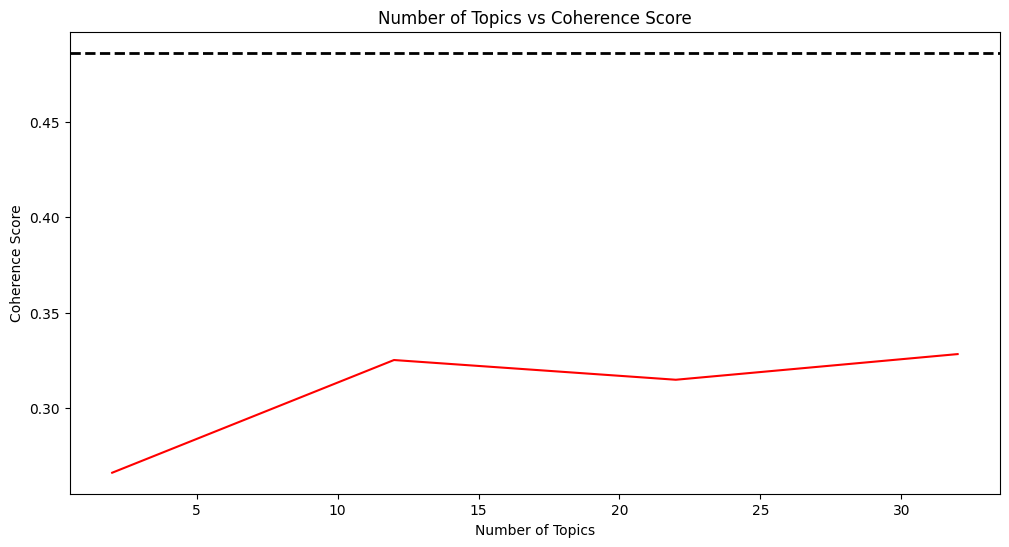

In [71]:
#Plot the number of topics vs coherence score
x_ax = range(2, 41, 2)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.486, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Number of Topics vs Coherence Score')
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

As seen in the above plot, the coherence score increases rapidly till 10 topics (coherence score = 0.486) and then starts to follow almost a horizontal trajectory, achieved the highest score at 18 topics(coherence_score=0.502).
Therefore for this corpus 10 topics and 18 topics seem like potential good options.

In [ ]:
coherence_scores[4],coherence_scores[8]

(0.48621979220006856, 0.5018786669754478)

In [ ]:
#save the lda_model with 10 topics
lda_10 = lda_models[4]
lda_18=lda_models[8]
lda_10.save('lda_10')
lda_18.save('lda_18')

2023-02-27 16:44:02,763 : INFO : LdaState lifecycle event {'fname_or_handle': 'lda_10.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-02-27T16:44:02.762857', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'saving'}
2023-02-27 16:44:02,765 : INFO : saved lda_10.state
2023-02-27 16:44:02,776 : INFO : LdaMulticore lifecycle event {'fname_or_handle': 'lda_10', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['state', 'dispatcher', 'id2word'], 'datetime': '2023-02-27T16:44:02.776727', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'saving'}
2023-02-27 16:44:02,777 : INFO : storing np array 'expElogbeta' to lda_10.expElogbeta.npy
2023-02-27 16:44:02,779 : INFO : not storing attribute state
2023-02-27 16:44:02,779 : INFO : 

In [ ]:
import pickle
#save the model
pickle.dump(lda_10, open('ldamodel_t10.pkl', 'wb'))
pickle.dump(lda_18, open('ldaModel_t18.pkl', 'wb'))

In [83]:
#load model
lda_10 = LdaModel.load('LDA_MODEL/lda_10')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
vis_data_10 = pyLDAvis.gensim.prepare(lda_10, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BrokenProcessPool: ignored

In [ ]:
vis_data_18 = pyLDAvis.gensim.prepare(lda_18, corpus, dictionary)

D:\software\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [85]:
pyLDAvis.display(vis_data_10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
pyLDAvis.display(vis_data_18)

In 18 topics, many topics are actually overlapped with each other, thus 10 topics LDA model was chosen for further interpretation of the topic names.

### Optimal Iteration

In [ ]:
#Iterate LdaMulticore model over varing passes
def model_coherence_generator_2(corpus, dictionary, data, passes):
    ldamodel = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, passes=passes, workers=10, random_state=42)
    cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
    score = cv_coherence_model.get_coherence()
    return ldamodel, score

#models = []
#coherence_scores = []
for passes in tqdm([1, 5, 10, 20, 40, 60, 80, 100]):
    model, score = model_coherence_generator_2(corpus, dictionary, df['Tokens'], passes)
    models.append(model)
    coherence_scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [33:38<00:00, 2018.38s/it]


In [ ]:
coherence_scores

[0.35615270842476654,
 0.4501174224234517,
 0.464733110474457,
 0.46918701431023235,
 0.47237584246599207,
 0.47387202498558506,
 0.4699180781373288,
 0.473581311212426]

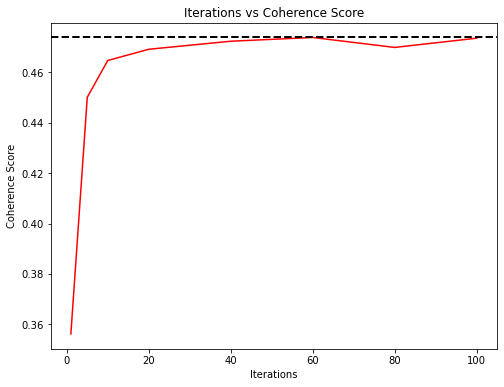

In [ ]:
#Plot the iteration times vs coherence score
x_ax = [1, 5, 10, 20, 40, 60, 80, 100]
y_ax = coherence_scores
plt.figure(figsize=(8, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y= 0.474, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Iterations vs Coherence Score')
xl = plt.xlabel('Iterations')
yl = plt.ylabel('Coherence Score')
plt.show()

Based on the plot, the coherence score increases rapidly with passes increases and achieved the highest score with passes=60.
Therefore, for the further topics extration, we will run LDA with topic_numbers=10, passes=60.

In [ ]:
lda_t10_p60 = models[6]

In [ ]:
lda_10_60 = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, passes=60, workers=20)
cv_coherence_model = CoherenceModel(model=lda_10_60, corpus = corpus, coherence='c_v', texts=df["Tokens"])
score = cv_coherence_model.get_coherence()
print(score)

0.48034246939196856


In [ ]:
lda_10_60.save('lda_10_p60')

In [ ]:
import pickle

In [ ]:
lda_10_60 = LdaModel.load('D:/DATA_SCIENCE/Project/CHATGPT/LDA_MODEL/lda_10_p60')

In [ ]:
pprint(lda_10_60.show_topics())

[(0,
  '0.028*"use" + 0.017*"build" + 0.016*"free" + 0.014*"make" + 0.011*"pay" + '
  '0.010*"app" + 0.010*"user" + 0.010*"openai" + 0.010*"version" + '
  '0.009*"open"'),
 (1,
  '0.108*"write" + 0.049*"use" + 0.036*"ask" + 0.025*"content" + '
  '0.022*"prompt" + 0.019*"generate" + 0.019*"create" + 0.014*"thread" + '
  '0.013*"article" + 0.013*"tweet"'),
 (2,
  '0.014*"ask" + 0.012*"love" + 0.011*"talk" + 0.010*"game" + 0.008*"play" + '
  '0.008*"new" + 0.007*"story" + 0.007*"world" + 0.007*"friend" + 0.007*"let"'),
 (3,
  '0.092*"google" + 0.066*"openai" + 0.035*"search" + 0.030*"microsoft" + '
  '0.028*"chatbot" + 0.021*"gpt" + 0.017*"openais" + 0.013*"via" + 0.013*"new" '
  '+ 0.012*"company"'),
 (4,
  '0.025*"ask" + 0.024*"like" + 0.020*"know" + 0.020*"answer" + 0.017*"think" '
  '+ 0.017*"say" + 0.017*"question" + 0.013*"make" + 0.013*"would" + '
  '0.012*"get"'),
 (5,
  '0.042*"year" + 0.027*"next" + 0.024*"day" + 0.021*"week" + 0.020*"take" + '
  '0.019*"time" + 0.016*"last" + 0

In [ ]:
pprint(lda_10.show_topics())

[(0,
  '0.061*"use" + 0.042*"code" + 0.024*"write" + 0.012*"help" + 0.012*"prompt" '
  '+ 0.011*"create" + 0.011*"build" + 0.011*"video" + 0.009*"learn" + '
  '0.009*"cod"'),
 (1,
  '0.022*"day" + 0.019*"twitter" + 0.015*"year" + 0.013*"week" + 0.013*"free" '
  '+ 0.012*"get" + 0.011*"last" + 0.010*"time" + 0.009*"take" + 0.009*"pay"'),
 (2,
  '0.042*"openai" + 0.026*"new" + 0.024*"technology" + 0.023*"tech" + '
  '0.020*"chatbot" + 0.017*"future" + 0.015*"via" + 0.013*"world" + '
  '0.013*"change" + 0.012*"artificial_intelligence"'),
 (3,
  '0.037*"use" + 0.031*"content" + 0.027*"generate" + 0.026*"create" + '
  '0.021*"tool" + 0.017*"text" + 0.016*"write" + 0.016*"make" + 0.013*"help" + '
  '0.012*"idea"'),
 (4,
  '0.022*"like" + 0.018*"think" + 0.018*"get" + 0.017*"know" + 0.017*"good" + '
  '0.017*"use" + 0.016*"thing" + 0.013*"people" + 0.012*"dont" + 0.012*"try"'),
 (5,
  '0.111*"google" + 0.042*"search" + 0.013*"search_engine" + 0.012*"microsoft" '
  '+ 0.011*"replace" + 0.010*"

In [ ]:
vis_data_10_60 = pyLDAvis.gensim.prepare(lda_10_60, corpus, dictionary)

D:\software\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.display(vis_data_10_60)

# Identification of Topics

In [ ]:
#get the topic distribution for each tweets
topic_dist = [lda_10_60[doc] for doc in corpus]

In [ ]:
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]

In [ ]:
#Create a dataframe to show dominant topic for each tweet
df_topic = df[['Tweet','Tokens','Date']].copy()
df_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
df_topic['Contribution%'] = [round(score*100,2) for score in scores]
df_topic.head()

,Tweet,Tokens,Date,Dominant_Topic,Contribution%
0,ChatGPT is basically the best unpaid intern to...,"[chatgpt, basically, best, unpaid, intern, eve...",2023-01-30,8,87.12
1,@jeffersonmorley @ChatGPT @OpenAI It pulled th...,"[pull, though]",2023-01-30,5,69.99
2,#ChatGPT is down for me since yesterday. Is it...,"[chatgpt, since, yesterday]",2023-01-30,8,69.99
3,@GalorOded ChatGPT is literally the marriage o...,"[chatgpt, literally, marriage, madlibs, monte,...",2023-01-30,6,26.25
4,ChatGPT Is Making Universities Rethink Plagiar...,"[chatgpt, make, university, rethink, plagiaris...",2023-01-30,9,63.12


In [ ]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Tweet':'count'}).copy().reset_index()
df_topic_summary.rename(columns={'Tweet':'Total_tweet'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_tweet']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_tweet', ascending=False).reset_index(drop=True)
df_topic_summary

,Dominant_Topic,Total_tweet,Percentage%
0,8,154146,18.51
1,5,148989,17.89
2,1,98785,11.86
3,2,88008,10.57
4,10,86441,10.38
5,7,71654,8.60
6,4,55814,6.70
7,3,54211,6.51
8,9,44713,5.37
9,6,30163,3.62


In [ ]:
#To sort the highly relevant tweets for each topics and interprete the topic names.
df_topic[df_topic['Dominant_Topic']==2].sort_values('Contribution%', ascending=False)[0:100]

,Tweet,Tokens,Date,Dominant_Topic,Contribution%,Topic_Name
324145,3. Use ChatGPT to create twitter thread outlin...,"['use', 'chatgpt', 'create', 'twitter', 'threa...",2023-01-13,2,96.40,T2 Content and Ideas Generation
631017,7. Create drafts of email newsletters and mark...,"['create', 'draft', 'email', 'newsletter', 'ma...",2022-12-14,2,96.25,T2 Content and Ideas Generation
47732,4/ #ChatGPT can also be used to generate email...,"['chatgpt', 'also', 'use', 'generate', 'email'...",2023-01-29,2,96.25,T2 Content and Ideas Generation
56274,4/ #ChatGPT can also be used to generate email...,"['chatgpt', 'also', 'use', 'generate', 'email'...",2023-01-29,2,96.25,T2 Content and Ideas Generation
448215,Let's make a quick recap \n8 businesses you ca...,"['let', 'make', 'quick', 'recap', 'business', ...",2023-01-06,2,96.25,T2 Content and Ideas Generation
478175,20. Amazon Product Descriptions\n\nChatGPT Pro...,"['amazon', 'product', 'description', 'chatgpt'...",2023-01-04,2,96.25,T2 Content and Ideas Generation
527975,5 / 5: Another interesting use case for ChatGP...,"['another', 'interesting', 'use', 'case', 'cha...",2022-12-28,2,96.25,T2 Content and Ideas Generation
718613,1. Draft writing and editing\n\nChatGPT can al...,"['draft', 'write', 'edit', 'chatgpt', 'also', ...",2022-12-08,2,96.09,T2 Content and Ideas Generation
409836,3. Writing Emails\n\nYou can have ChatGPT spin...,"['write', 'email', 'chatgpt', 'spin', 'specifi...",2023-01-09,2,96.08,T2 Content and Ideas Generation
156793,7. Use ChatGPT to create outline structures fo...,"['use', 'chatgpt', 'create', 'outline', 'struc...",2023-01-24,2,96.08,T2 Content and Ideas Generation


In [ ]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets
names = {1:"T1 ChatGPT's Cost and Access",
        2:"T2 Content and Ideas Generation",
        3:"T3 Entertainment and Activities",
        4:"T4 Competition of AI Giants",
        5:"T5 ChatGTP's Issues and Reliability",
        6:"T6 Developments and Milestones of ChatGPT",
        7:"T7 Impacts on Future Business and Industry",
        8:"T8 Impacts on Work and Efficiency",
        9:"T9 Impacts on Education and Academy",
        10:"T10 Natural Language Processing"
        }

In [ ]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)
df_topic.to_csv('Twitter_topics.csv', index=False)

In [ ]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, weight in lda_10_60.show_topic(n,topn=20)] for n in range(0,lda_10_60.num_topics)]

In [ ]:
pd.set_option('display.max_colwidth', None)
topic_df = pd.DataFrame({'Topic_Name':names.values(),
                         'Topic_Terms':[','.join([term for term, weight in topic]) for topic in topics]},
                        index = ['Topic ' + str(n) for n in range(1,lda_10_60.num_topics+1)])
# apply style to align content to the left
topic_df

,Topic_Name,Topic_Terms
Topic 1,T1 ChatGPT's Cost and Access,"use,build,free,make,pay,app,user,openai,version,open,run,money,get,access,api,twitter,like,chat,bot,create"
Topic 2,T2 Content and Ideas Generation,"write,use,ask,content,prompt,generate,create,thread,article,tweet,help,idea,video,story,make,script,code,book,read,get"
Topic 3,T3 Entertainment and Activities,"ask,love,talk,game,play,new,story,world,friend,let,amp,live,bitcoin,whats,thanks,poem,conversation,today,name,best"
Topic 4,T4 Competition of AI Giants,"google,openai,search,microsoft,chatbot,gpt,openais,via,new,company,billion,search_engine,launch,bing,say,news,creator,could,tech,investment"
Topic 5,T5 ChatGTP's Issues and Reliability,"ask,like,know,answer,think,say,question,make,would,get,dont,people,give,even,tell,doesnt,one,good,thing,wrong"
Topic 6,T6 Developments and Milestones of ChatGPT,"year,next,day,week,take,time,last,text,image,dalle,one,first,paper,month,old,art,two,midjourney,ago,release"
Topic 7,T7 Impacts on Future Business and Industry,"future,technology,tech,world,new,change,amp,tool,via,business,way,potential,like,web,openai,artificial_intelligence,machinelearning,learn,job,industry"
Topic 8,T8 Impacts on Work and Efficiency,"use,get,try,good,work,code,thing,ive,see,time,like,think,really,well,people,job,make,need,lot,much"
Topic 9,T9 Impacts on Education and Academy,"student,use,education,school,essay,teacher,teach,ban,exam,new,pass,cheat,learn,tool,kid,law,via,concern,college,assignment"
Topic 10,T10 Natural Language Processing,"model,use,data,language,question,answer,human,train,information,provide,response,text,generate,conversation,gpt,give,understand,base,also,like"


In [ ]:
df_temp = df_topic_summary.sort_values('Dominant_Topic')
topic_df['Tweet_count'] = df_temp['Total_tweet'].values
topic_df

,Topic_Name,Topic_Terms,Tweet_count
Topic 1,T1 ChatGPT's Cost and Access,"use,build,free,make,pay,app,user,openai,version,open,run,money,get,access,api,twitter,like,chat,bot,create",98785
Topic 2,T2 Content and Ideas Generation,"write,use,ask,content,prompt,generate,create,thread,article,tweet,help,idea,video,story,make,script,code,book,read,get",88008
Topic 3,T3 Entertainment and Activities,"ask,love,talk,game,play,new,story,world,friend,let,amp,live,bitcoin,whats,thanks,poem,conversation,today,name,best",54211
Topic 4,T4 Competition of AI Giants,"google,openai,search,microsoft,chatbot,gpt,openais,via,new,company,billion,search_engine,launch,bing,say,news,creator,could,tech,investment",55814
Topic 5,T5 ChatGTP's Issues and Reliability,"ask,like,know,answer,think,say,question,make,would,get,dont,people,give,even,tell,doesnt,one,good,thing,wrong",148989
Topic 6,T6 Developments and Milestones of ChatGPT,"year,next,day,week,take,time,last,text,image,dalle,one,first,paper,month,old,art,two,midjourney,ago,release",30163
Topic 7,T7 Impacts on Future Business and Industry,"future,technology,tech,world,new,change,amp,tool,via,business,way,potential,like,web,openai,artificial_intelligence,machinelearning,learn,job,industry",71654
Topic 8,T8 Impacts on Work and Efficiency,"use,get,try,good,work,code,thing,ive,see,time,like,think,really,well,people,job,make,need,lot,much",154146
Topic 9,T9 Impacts on Education and Academy,"student,use,education,school,essay,teacher,teach,ban,exam,new,pass,cheat,learn,tool,kid,law,via,concern,college,assignment",44713
Topic 10,T10 Natural Language Processing,"model,use,data,language,question,answer,human,train,information,provide,response,text,generate,conversation,gpt,give,understand,base,also,like",86441


D:\software\Anaconda\lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


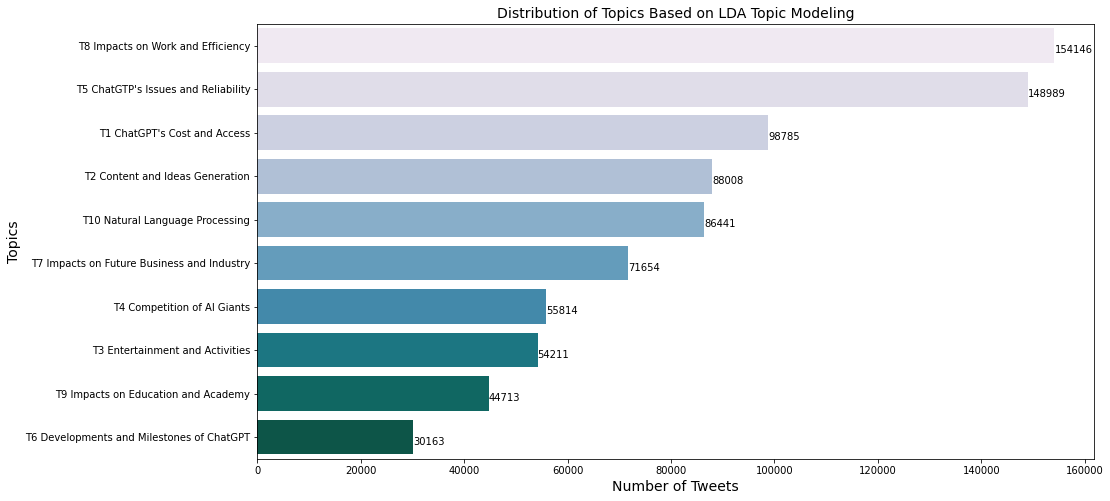

In [ ]:
#plot a bar chart to show the number of tweets for each topic
sort_name = topic_df.sort_values('Tweet_count',ascending=False)['Topic_Name'].to_list()
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Tweet_count'], order=sort_name, palette='PuBuGn')
for i in ax.patches:
    ax.annotate(int(i.get_width()), (i.get_width(), i.get_y()+0.5), va='center')
ax.set_ylabel('Topics', size=14)
ax.set_xlabel('Number of Tweets', size=14)
ax.set_title('Distribution of Topics Based on LDA Topic Modeling', size=14)

plt.show()

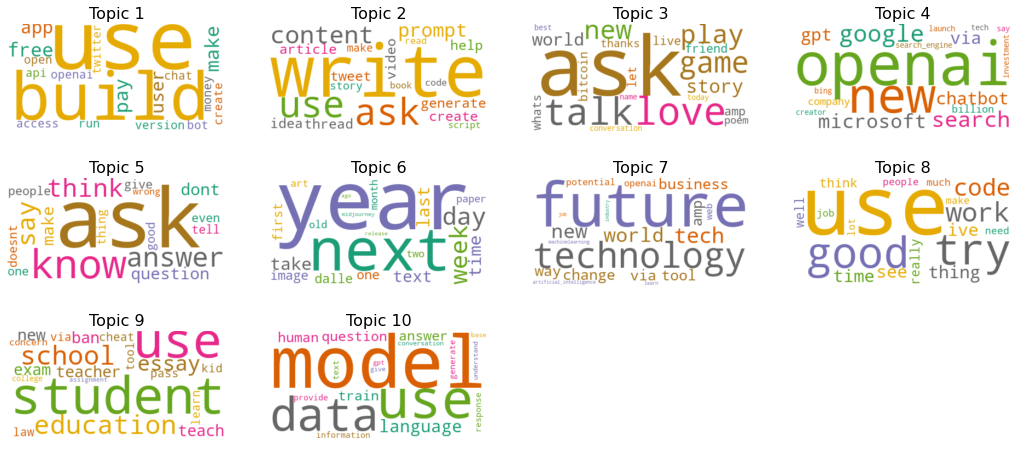

In [ ]:
# word cloud
from wordcloud import WordCloud
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
fig, axs = plt.subplots(3,4, figsize=(18,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    if i<10:
        wc.generate(topic_df['Topic_Terms'][i])
        plt.subplot(3,4,i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(topic_df.index[i], size=16)
    plt.axis('off')

plt.show()
